Generating single-octave Perlin noise with base frequency multiplier: x9 (actual freq: 0.4091)...
Generated in 0.18 seconds.


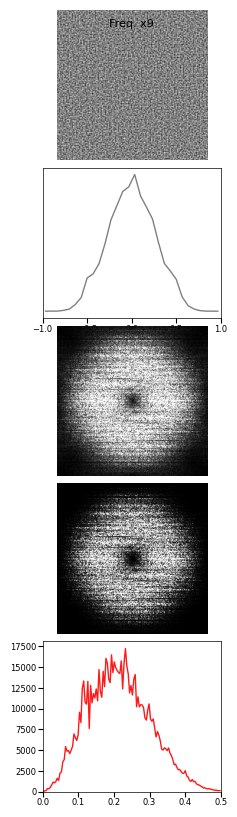


Stats for last noise (freq multiplier x9):
Min: -0.9923, Max: 0.9620, Mean: -0.0001, Std: 0.2636


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import time # For checking generation time

# --- Perlin Noise Implementation (Scratch) ---
# (PerlinNoiseGenerator class and helper functions remain the same as previous correct version)
def fade(t):
    return t * t * t * (t * (t * 6 - 15) + 10)

def lerp(a, b, t):
    return a + t * (b - a)

def grad(hash_val, x, y):
    h = hash_val & 7
    if h == 0: return  x + y
    if h == 1: return -x + y
    if h == 2: return  x - y
    if h == 3: return -x - y
    if h == 4: return  x
    if h == 5: return -x
    if h == 6: return       y
    if h == 7: return      -y
    return 0

class PerlinNoiseGenerator:
    def __init__(self, seed=0):
        self.p = np.arange(256, dtype=int)
        np.random.seed(seed)
        np.random.shuffle(self.p)
        self.perm = np.concatenate((self.p, self.p))

    def _noise_single_octave(self, x, y):
        xi = int(x); yi = int(y)
        xf = x - xi; yf = y - yi
        xi_wrapped = xi & 255; yi_wrapped = yi & 255
        u = fade(xf); v = fade(yf)

        g00_hash = self.perm[self.perm[xi_wrapped] + yi_wrapped]
        g10_hash = self.perm[self.perm[xi_wrapped + 1] + yi_wrapped]
        g01_hash = self.perm[self.perm[xi_wrapped] + yi_wrapped + 1]
        g11_hash = self.perm[self.perm[xi_wrapped + 1] + yi_wrapped + 1]

        n00 = grad(g00_hash, xf, yf)
        n10 = grad(g10_hash, xf - 1, yf)
        n01 = grad(g01_hash, xf, yf - 1)
        n11 = grad(g11_hash, xf - 1, yf - 1)

        nx0 = lerp(n00, n10, u)
        nx1 = lerp(n01, n11, u)
        noise_val = lerp(nx0, nx1, v)
        return noise_val

    def generate_fractal_noise(self, img_size_x, img_size_y,
                               initial_frequency, octaves, persistence, lacunarity,
                               offset_x=0, offset_y=0):
        data = np.zeros((img_size_y, img_size_x))
        total_amplitude = 0.0
        current_amplitude = 1.0
        current_frequency_x = initial_frequency
        current_frequency_y = initial_frequency

        for _ in range(octaves): # Will be 1 in our case
            total_amplitude += current_amplitude
            for r in range(img_size_y):
                for c in range(img_size_x):
                    sample_x = (c + offset_x) * current_frequency_x
                    sample_y = (r + offset_y) * current_frequency_y
                    data[r, c] += self._noise_single_octave(sample_x, sample_y) * current_amplitude
            current_amplitude *= persistence
            current_frequency_x *= lacunarity
            current_frequency_y *= lacunarity
        
        if total_amplitude > 0:
            data /= total_amplitude # For single octave, total_amplitude = 1
        return data

# --- Plotting Function (adapted for multiple columns) ---
def plot_noise_analysis(noise_array, frequency_multiplier_title, fig_axs_column):
    axs = fig_axs_column

    # Row 1: Noise Image
    display_noise_image = (noise_array - np.min(noise_array)) / (np.max(noise_array) - np.min(noise_array))
    axs[0].imshow(display_noise_image, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title(f"Freq. x{frequency_multiplier_title}", fontsize=8, y=1.0, pad=-12)

    # Row 2: Intensity Distribution
    intensity_values_raw = noise_array.flatten()
    # Single octave Perlin output is roughly in [-0.7, 0.7]
    hist_range = (-1, 1)
    intensity_values_clamped = np.clip(intensity_values_raw, hist_range[0], hist_range[1])
    hist_raw, bin_edges_raw = np.histogram(intensity_values_clamped, bins=30, range=hist_range, density=True)
    bin_centers_raw = (bin_edges_raw[:-1] + bin_edges_raw[1:]) / 2
    axs[1].plot(bin_centers_raw, hist_raw, color='gray', linewidth=1)
    axs[1].set_xlim(hist_range[0], hist_range[1])

    # Row 3: Fourier Transform Magnitude
    noise_for_fft = noise_array - np.mean(noise_array)
    F = np.fft.fft2(noise_for_fft)
    F_shifted = np.fft.fftshift(F)
    F_magnitude = np.abs(F_shifted)
    vmax_fft = np.percentile(F_magnitude[F_magnitude > 0], 98) if np.any(F_magnitude > 0) else 1
    axs[2].imshow(F_magnitude, cmap='gray', vmin=0, vmax=vmax_fft * 0.5)

    # Row 4: Power Spectrum
    power_spectrum = F_magnitude**2
    vmax_ps = np.percentile(power_spectrum[power_spectrum > 0], 98) if np.any(power_spectrum > 0) else 1
    axs[3].imshow(power_spectrum, cmap='gray', vmin=0, vmax=vmax_ps * 0.3)

    # Row 5: Radial Power Spectrum
    IMG_SIZE_local = noise_array.shape[0]
    center_x, center_y = IMG_SIZE_local // 2, IMG_SIZE_local // 2
    y_idx, x_idx = np.indices((IMG_SIZE_local, IMG_SIZE_local))
    r = np.sqrt((x_idx - center_x)**2 + (y_idx - center_y)**2)

    max_k_radius_pixels = IMG_SIZE_local // 2
    num_radial_bins = max_k_radius_pixels
    radial_bin_edges = np.arange(num_radial_bins + 1)
    radial_power = np.zeros(num_radial_bins)
    radial_freq_axis_pixels = radial_bin_edges[:-1] + 0.5

    for k_bin_idx in range(num_radial_bins):
        lower_r = radial_bin_edges[k_bin_idx]
        upper_r = radial_bin_edges[k_bin_idx+1]
        mask = (r >= lower_r) & (r < upper_r)
        values_in_bin = power_spectrum[mask]
        if len(values_in_bin) > 0:
            radial_power[k_bin_idx] = np.mean(values_in_bin)
        else:
            radial_power[k_bin_idx] = 0

    radial_freq_axis_normalized_plot = radial_freq_axis_pixels / IMG_SIZE_local
    axs[4].plot(radial_freq_axis_normalized_plot, radial_power, color='red', alpha=0.9, linewidth=1)
    axs[4].set_xlim(0, 0.5)
    axs[4].set_ylim(bottom=0)

    # Optional: Scale Y-axis for the first column (freq_multiplier=1) to match paper's Perlin
    if frequency_multiplier_title == 1 and np.max(radial_power) > 0:
        max_val_paper_perlin_radial = 0.12
        current_max_val = np.max(radial_power)
        scaling_factor = max_val_paper_perlin_radial / current_max_val if current_max_val > 0 else 1.0
        axs[4].clear()
        axs[4].plot(radial_freq_axis_normalized_plot, radial_power * scaling_factor, color='red', alpha=0.9, linewidth=1)
        axs[4].set_ylim(0, max_val_paper_perlin_radial * 1.1)
        axs[4].set_xlim(0, 0.5)


    # Common subplot styling
    for i, ax_h in enumerate(axs):
        if i not in [1, 4]:
            ax_h.axis('off')
        else:
            ax_h.tick_params(axis='x', labelsize=6, pad=1)
            ax_h.tick_params(axis='y', labelsize=6, pad=1)
            if i == 1: ax_h.set_yticks([])
        ax_h.set_frame_on(True)
        for spine in ax_h.spines.values():
            spine.set_edgecolor('black'); spine.set_linewidth(0.5)

# --- Main Execution ---
IMG_SIZE = 256
# Base frequency that corresponds to the paper's Perlin noise (wavelength ~22 pixels)
BASE_UNIT_FREQUENCY = 1.0 / 22.0
SEED = 0
OFFSET_X, OFFSET_Y = 0, 0 # Can be used to sample different parts of the noise field

# These are the multipliers for the BASE_UNIT_FREQUENCY
frequency_multipliers = [9]
num_columns = len(frequency_multipliers)

fig, all_axs = plt.subplots(5, num_columns, figsize=(num_columns * 2.2, 8.0), squeeze=False)
perlin_generator = PerlinNoiseGenerator(seed=SEED)

for col_idx, freq_multiplier in enumerate(frequency_multipliers):
    current_initial_frequency = BASE_UNIT_FREQUENCY * freq_multiplier
    
    print(f"Generating single-octave Perlin noise with base frequency multiplier: x{freq_multiplier} (actual freq: {current_initial_frequency:.4f})...")
    start_time = time.time()
    
    # Always use 1 octave
    raw_noise_data = perlin_generator.generate_fractal_noise(
        IMG_SIZE, IMG_SIZE,
        initial_frequency=current_initial_frequency,
        octaves=1, # Key: always 1 octave
        persistence=0.5, # Not very relevant for 1 octave
        lacunarity=2.0,  # Not very relevant for 1 octave
        offset_x=OFFSET_X, offset_y=OFFSET_Y
    )
    
    end_time = time.time()
    print(f"Generated in {end_time - start_time:.2f} seconds.")

    current_column_axes = all_axs[:, col_idx]
    plot_noise_analysis(raw_noise_data, freq_multiplier, current_column_axes)

plt.tight_layout(pad=0.1, h_pad=0.05, w_pad=0.05)
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.savefig(f"perlin_scratch_freq_multipliers_1_to_{num_columns}.png", dpi=150)
plt.show()

if 'raw_noise_data' in locals():
    print(f"\nStats for last noise (freq multiplier x{freq_multiplier}):")
    print(f"Min: {np.min(raw_noise_data):.4f}, Max: {np.max(raw_noise_data):.4f}, Mean: {np.mean(raw_noise_data):.4f}, Std: {np.std(raw_noise_data):.4f}")

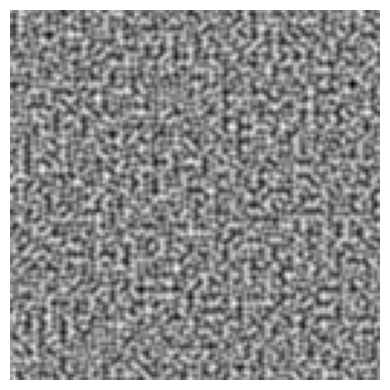


已保存128x128裁切图到 perlin_scratch_cropped_128x128.png


In [28]:
# 生成128x128的裁切图
crop_size = 128
start_x = (IMG_SIZE - crop_size) // 2
start_y = (IMG_SIZE - crop_size) // 2
cropped_noise = raw_noise_data[start_y:start_y+crop_size, start_x:start_x+crop_size]

# 创建新的图形来显示裁切图
plt.figure(figsize=(4, 4))
plt.imshow(cropped_noise, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig("perlin_scratch_cropped_128x128.png", dpi=150)
plt.show()

print("\n已保存128x128裁切图到 perlin_scratch_cropped_128x128.png")